In [1]:
# ---- Librerías estándar ----
import os
import time
import gc
import tempfile
import joblib

# ---- Data manipulation ----
import pandas as pd
import numpy as np

# ---- Visualization ----
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ---- Scikit-learn: Model Selection ----
from sklearn.model_selection import KFold, cross_val_score, learning_curve

# ---- Scikit-learn: Metrics ----
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer,
    accuracy_score,
    f1_score,
    confusion_matrix
)

# ---- Scikit-learn: Models ----
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# ---- Scikit-learn: Utils ----
from sklearn.utils import shuffle

# ---- MLflow ----
import mlflow
import mlflow.sklearn


## Lectura del Dataset

In [2]:
path = r"C:\Users\Lenovo\Documents\universidad\Especializacion\ProyectoSegundoSemestrePDS\Tablas Finales"
file_path = os.path.join(path, "df_filtrado_v2.parquet")
df = pd.read_parquet(file_path)

In [3]:
columnas_fecha = [
    "HistorialODSFechaHora","HistorialODSAsignadaFecha","HistorialODSReasignadaFecha",
    "HistorialODSDiagnosticadoFecha","HistorialODSReparacionFecha","HistorialODSPedidoProvFecha",
    "HistorialODSSolicitudRptoFecha","HistorialODSRptoOkFecha","HistorialODSControlCalidadFech",
    "HistorialODSFechaCotiza","HistorialODSFechaAprobaCoti","HistorialODSEntregadoFecha",
    "HistorialODSGuiaFechaEnvio","HistorialODSFechaReciboGuia","HistorialODSFechaCompra",
    "HistorialODSFechaGuiaTras2","HistorialODSFechaGuiaTras1","HistorialODSFechaFinalServicio",
    "HistorialODSFechaIniciaServici","HistorialODSFechaEquipoEnvia","HistorialODSFechaSinAtender",
    "HistorialODSFechaValidaAdmon","HistorialODSFechaAsumidoPDS",
    "ODSRecepcionGarantiaFechaCompr","ODSRecepcionFechaGuiaTras","ODSRecepcionFechaGuia",
    "ODSRecepcionGuiaFechaRecibo","ODSRecepcionGuiaFechaEnvio","ODSRecepcionFechaHoraTransito",
    "ODSRecepcionFechaBloqueo","ODSRecepcionFechaRecibeTraslad","ODSRecepcionFechaRuta",
    "ODSRecepcionFechaModifica","ODSRecepcionFechaPagoFactura",
    "ODSRecepcionFechaPago","ODSRecepcionFechaBodega","ODSRecepcionFechaDevuelveBodeg",
    "ODSRecepcionFechaEscalacion","ODSRecepcionDevuelveFechaEscal","ODSRecepcionFechaEscalaF",
    "ODSRecepcionFechaDevuelveEscal","ODSRecepcionFechaDiagnostico","ODSRecepcionFechaReparacion",
    "ODSRecepcionFechaSinAtender","ODSRecepcionFechaAsignacion","ODSRecepcionFechaRepuestoOk",
    "ODSRecepcionFechaPedidoRpto","ODSRecepcionFechaControlCalida","ODSRecepcionFechaAnulacion",
    "ODSRecepcionFechaCotizacion","ODSRecepcionFechaRevisarRep","ODSRecepcionFechaVisita",
    "ODSRecepcionFechaTecVisita","ODSRecepcionTrasladoFecha","ODSRecepcionGarantiaFechaFinal",
    "ODSRecepcionFechaEntregaTemp","ODSRecepcionHoraVisita","ODSRecepcionFechaGuiaTras2",
    "ODSRecepcionFechaPQR","ODSRecepcionFechaEquipoEnvia","fecha_registro_estado",
    "RepuestosFecha","HistorialODSEnTransito","ODSRecepcionEntregaRpto"
]

In [4]:
df_modelo = df.copy()

In [5]:
df_modelo = df_modelo.drop(columns=columnas_fecha)

In [6]:
columnas_fecha_convertir = [
    "ODSRecepcionFechaHora","ODSRecepcionFechaEntregaFinal"
]

Convertir columnas a datetime y reemplazar fechas inválidas

In [7]:
for col in columnas_fecha_convertir:
    df_modelo[col] = pd.to_datetime(df_modelo[col], errors='coerce')  # convierte o pone NaT si no puede
    df_modelo.loc[df[col] == pd.Timestamp("1753-01-01 00:00:00"), col] = pd.NaT  # reemplaza las 1753 por nulo

### Funcion para columnas con valores nulos

In [8]:
def resumen_valores_nulos(df, mostrar=True):
    total_filas = len(df)
    nulos = df.isnull().sum().sort_values(ascending=False)
    porcentaje_nulos = (nulos / total_filas * 100).sort_values(ascending=False)
    resumen = pd.DataFrame({
        'Nulos': nulos,
        '% Nulos': porcentaje_nulos.round(2)
    })
    resumen = resumen[resumen['Nulos'] > 0]
    if mostrar:
        print(resumen)
    return resumen

In [9]:
def eliminar_columnas_nulas(df_input, umbral=0.7):
    total_filas = len(df_input)
    porcentaje_nulos = df_input.isnull().sum() / total_filas
    cols_a_eliminar = porcentaje_nulos[porcentaje_nulos > umbral].index.tolist()
    print(f"Se eliminarán {len(cols_a_eliminar)} columnas ({round(len(cols_a_eliminar)/len(df_input.columns)*100,2)}% del total).")
    return df_input.drop(columns=cols_a_eliminar)

In [10]:
resumen_valores_nulos(df_modelo)

                              Nulos  % Nulos
EstadoId                      22795     3.42
EstadoNombre                  22795     3.42
EstadoTipo                    22795     3.42
HistorialODSAccionRepara     295420    44.28
HistorialODSAltaImportancia    6683     1.00
...                             ...      ...
registrado_por               205694    30.83
rpto_id                      205192    30.76
sede_id                      205192    30.76
sintoma_dano                 315923    47.35
solicitud_id                 205192    30.76

[163 rows x 2 columns]


,Nulos,% Nulos
EstadoId,22795,3.42
EstadoNombre,22795,3.42
EstadoTipo,22795,3.42
HistorialODSAccionRepara,295420,44.28
HistorialODSAltaImportancia,6683,1.00
...,...,...
registrado_por,205694,30.83
rpto_id,205192,30.76
sede_id,205192,30.76
sintoma_dano,315923,47.35


### Eliminar columnas con mas del 70% de valores nulos

In [11]:
df_limpio = eliminar_columnas_nulas(df_modelo, umbral=0.7)

Se eliminarán 0 columnas (0.0% del total).


In [12]:
df_limpio['SLA_dias'] = (df_limpio['ODSRecepcionFechaEntregaFinal'] - df_limpio['ODSRecepcionFechaHora']).dt.total_seconds() / 86400

In [13]:
df_limpio['SLA_dias']

0                  NaN
1                  NaN
2                  NaN
3        -99487.885104
4             0.984931
              ...     
687147             NaN
687148       76.045625
687149       76.045625
687150       76.045625
687151       22.758762
Name: SLA_dias, Length: 667181, dtype: float64

In [14]:
df_limpio = df_limpio.dropna(subset=['SLA_dias'])

In [15]:
numericas = df_limpio.select_dtypes(include=['number', 'datetime', 'bool'])

In [16]:
correlaciones = numericas.corr()['SLA_dias'].sort_values(ascending=False)

In [17]:
correlaciones

SLA_dias                         1.000000
ODSRecepcionFechaEntregaFinal    0.999418
ODSRecepcionResultadoEncuesta    0.770320
ODSRecepcionLocalPais            0.126484
HistorialODSEntregaWeb           0.118387
                                   ...   
ODSRecepcionOrdenRuta                 NaN
ODSRecepcionSeleccion                 NaN
ODSRecepcionOrdenVisita               NaN
ODSRecepcionDiagTecValor              NaN
ODSRecepcionNroCotizacion             NaN
Name: SLA_dias, Length: 85, dtype: float64

In [18]:
umbral = 0.025

In [19]:
correlaciones = numericas.corr()['SLA_dias'].abs()

In [20]:
correlaciones

HistorialODSDiagId              0.024857
HistorialODSDiagProblema        0.037746
HistorialODSDiagAccion          0.076596
HistorialODSDiagReparaAccion         NaN
HistorialODSSede                0.009985
                                  ...   
diagnostico_id                  0.104410
rpto_id                         0.021476
RepuestosId                     0.021502
RepuestosExistencia             0.000342
SLA_dias                        1.000000
Name: SLA_dias, Length: 85, dtype: float64

In [21]:
columnas_importantes = correlaciones[correlaciones >= umbral].index.tolist()

In [22]:
df_filtrado = df_limpio[columnas_importantes]

In [23]:
print("Columnas seleccionadas:", columnas_importantes)

Columnas seleccionadas: ['HistorialODSDiagProblema', 'HistorialODSDiagAccion', 'HistorialODSMarca', 'HistorialODSTipoEquipo', 'HistorialODSEstado', 'HistorialODSTipoServicio', 'HistorialODSConfigFabrica', 'HistorialODSSedeEntrega', 'HistorialODSDpto', 'HistorialODSAltaImportancia', 'HistorialODSFallaNTF', 'HistorialODSEntregaWeb', 'ProblemasId', 'ProblemasTipo', 'TipoProblemaId', 'ODSRecepcionFechaHora', 'ODSRecepcionConfigFabrica', 'ODSRecepcionTipoEquipo', 'ODSRecepcionMarca', 'ODSRecepcionEstado', 'ODSRecepcionGarantiaVigencia', 'ODSRecepcionRecepcionPais', 'ODSRecepcionRecepcionDpto', 'ODSRecepcionLocalPais', 'ODSRecepcionLocalDpto', 'ODSRecepcionLocalCiudad', 'ODSRecepcionTipoServicio', 'ODSRecepcionFechaEntregaFinal', 'ODSRecepcionResultadoEncuesta', 'ODSRecepcionSedeEntrega', 'ODSRecepcionEstadoAntBodega', 'ODSRecepcionFallaSistema', 'ODSRecepcionChecklist', 'ODSRecepcionAltaImportancia', 'ODSRecepcionMarcaEquipoP', 'ODSRecepcionValorGuiaTras2', 'EstadoId', 'MarcaId', 'solicitud

In [24]:
columnas_a_eliminar = [
    "HistorialODSDiagAccion",
    "HistorialODSFallaNTF",
    "ODSRecepcionEstado",
    "ODSRecepcionGarantiaVigencia",
    "ODSRecepcionRecepcionPais",
    "ODSRecepcionResultadoEncuesta",
    "ODSRecepcionEstadoAntBodega",
    "EstadoId",
    "solicitud_id",
    "diagnostico_id"
]

In [25]:
df_to_model = df_filtrado.drop(columns=columnas_a_eliminar)

In [26]:
df_to_model.head()

,HistorialODSDiagProblema,HistorialODSMarca,HistorialODSTipoEquipo,HistorialODSEstado,HistorialODSTipoServicio,HistorialODSConfigFabrica,HistorialODSSedeEntrega,HistorialODSDpto,HistorialODSAltaImportancia,HistorialODSEntregaWeb,...,ODSRecepcionTipoServicio,ODSRecepcionFechaEntregaFinal,ODSRecepcionSedeEntrega,ODSRecepcionFallaSistema,ODSRecepcionChecklist,ODSRecepcionAltaImportancia,ODSRecepcionMarcaEquipoP,ODSRecepcionValorGuiaTras2,MarcaId,SLA_dias
3,185,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,1753-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-99487.885104
4,87,3.0,4.0,24.0,14.0,11527.0,0.0,0.0,0.0,1.0,...,14.0,2023-09-05 13:00:53,0.0,7.0,0.0,0.0,0.0,0.0,3.0,0.984931
5,179,2.0,3.0,38.0,14.0,11234.0,0.0,14.0,0.0,0.0,...,14.0,2023-10-05 16:13:01,0.0,0.0,0.0,1.0,5.0,0.0,2.0,22.946539
6,179,2.0,3.0,38.0,14.0,11234.0,0.0,14.0,0.0,0.0,...,14.0,2023-10-05 16:13:01,0.0,0.0,0.0,1.0,5.0,0.0,2.0,22.946539
7,51,3.0,4.0,24.0,14.0,10993.0,0.0,0.0,0.0,1.0,...,14.0,2023-09-25 17:30:40,0.0,7.0,0.0,0.0,0.0,0.0,3.0,3.731713


### Manejo de variables fecha

In [27]:
df_to_model['Fecha_ingreso_dia'] = df_to_model['ODSRecepcionFechaHora'].dt.day
df_to_model['Fecha_ingreso_mes'] = df_to_model['ODSRecepcionFechaHora'].dt.month
df_to_model['Fecha_ingreso_ano'] = df_to_model['ODSRecepcionFechaHora'].dt.year

In [28]:
df_to_model = df_to_model.drop(columns=['ODSRecepcionFechaHora','ODSRecepcionFechaEntregaFinal'])

## Manejo de valores anomalos

In [29]:
def analizar_nulos(df):
    nulos = pd.DataFrame({
        'Columna': df.columns,
        'Valores_Nulos': df.isnull().sum(),
        'Porcentaje': (df.isnull().sum() / len(df) * 100).round(2),
        'Tipo_Dato': df.dtypes
    })
    nulos = nulos[nulos['Valores_Nulos'] > 0].sort_values('Valores_Nulos', ascending=False)
    return nulos

print("=== VALORES NULOS ===")
nulos_df = analizar_nulos(df_to_model)
print(nulos_df)


=== VALORES NULOS ===
                                                 Columna  Valores_Nulos  \
MarcaId                                          MarcaId          11805   
HistorialODSTipoServicio        HistorialODSTipoServicio           6555   
HistorialODSConfigFabrica      HistorialODSConfigFabrica           6555   
HistorialODSSedeEntrega          HistorialODSSedeEntrega           6555   
HistorialODSDpto                        HistorialODSDpto           6555   
HistorialODSAltaImportancia  HistorialODSAltaImportancia           6555   
HistorialODSEntregaWeb            HistorialODSEntregaWeb           6555   
HistorialODSMarca                      HistorialODSMarca           6553   
HistorialODSTipoEquipo            HistorialODSTipoEquipo           6553   
HistorialODSEstado                    HistorialODSEstado           6553   
ProblemasId                                  ProblemasId            352   
ProblemasTipo                              ProblemasTipo            352   
Tip

### Funcion para manejar valores nulos

In [30]:
def manejar_nulos(df, estrategia='auto'):
    df_limpio = df.copy()
    if estrategia == 'auto':
        cols_a_eliminar = df_limpio.columns[df_limpio.isnull().mean() > 0.5]
        df_limpio = df_limpio.drop(columns=cols_a_eliminar)
        for col in df_limpio.select_dtypes(include=[np.number]).columns:
            if df_limpio[col].isnull().any():
                df_limpio[col] = df_limpio[col].fillna(df_limpio[col].median())
        for col in df_limpio.select_dtypes(include='object').columns:
            if df_limpio[col].isnull().any():
                moda = df_limpio[col].mode()[0]
                df_limpio[col] = df_limpio[col].fillna(moda)

    elif estrategia == 'eliminar':
        df_limpio = df_limpio.dropna()

    elif estrategia == 'forward_fill':
        df_limpio = df_limpio.fillna(method='ffill').fillna(method='bfill')

    return df_limpio

In [31]:
df_limpio_withou_null = manejar_nulos(df_to_model, estrategia='auto')

In [32]:
print(f"\n=== DESPUÉS DEL MANEJO ===")
print(f"Filas originales: {len(df_to_model)}")
print(f"Filas después del manejo: {len(df_limpio_withou_null)}")
print(f"Valores nulos restantes: {df_limpio_withou_null.isnull().sum().sum()}")


=== DESPUÉS DEL MANEJO ===
Filas originales: 644395
Filas después del manejo: 644395
Valores nulos restantes: 0


### Resumen final

In [33]:
print("\n=== RESUMEN DEL DATASET LIMPIO ===")
print(df_limpio_withou_null.info())


=== RESUMEN DEL DATASET LIMPIO ===
<class 'pandas.core.frame.DataFrame'>
Index: 644395 entries, 3 to 687151
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   HistorialODSDiagProblema     644395 non-null  int64  
 1   HistorialODSMarca            644395 non-null  float64
 2   HistorialODSTipoEquipo       644395 non-null  float64
 3   HistorialODSEstado           644395 non-null  float64
 4   HistorialODSTipoServicio     644395 non-null  float64
 5   HistorialODSConfigFabrica    644395 non-null  float64
 6   HistorialODSSedeEntrega      644395 non-null  float64
 7   HistorialODSDpto             644395 non-null  float64
 8   HistorialODSAltaImportancia  644395 non-null  float64
 9   HistorialODSEntregaWeb       644395 non-null  float64
 10  ProblemasId                  644395 non-null  float64
 11  ProblemasTipo                644395 non-null  float64
 12  TipoProblemaId             

In [34]:
print("\nEstadísticas:")
print(df_limpio_withou_null.describe())


Estadísticas:
       HistorialODSDiagProblema  HistorialODSMarca  HistorialODSTipoEquipo  \
count             644395.000000      644395.000000           644395.000000   
mean                  79.257271           9.059054                2.803600   
std                   66.725714          15.646466                5.438796   
min                    0.000000           0.000000                0.000000   
25%                   22.000000           2.000000                1.000000   
50%                   54.000000           3.000000                1.000000   
75%                  120.000000           3.000000                1.000000   
max                  237.000000         102.000000               38.000000   

       HistorialODSEstado  HistorialODSTipoServicio  \
count       644395.000000             644395.000000   
mean            25.518957                  7.296806   
std              5.663297                  5.614334   
min              0.000000                  0.000000   
25%    

### Seleccion de anomalías en SLA_dias

In [35]:
df_limpio_withou_null = df_limpio_withou_null[df_limpio_withou_null['SLA_dias'] >= 0]

In [36]:
q_low = df_limpio_withou_null['SLA_dias'].quantile(0.01)
q_high = df_limpio_withou_null['SLA_dias'].quantile(0.99)

In [37]:
df_limpio_withou_null = df_limpio_withou_null[
    (df_limpio_withou_null['SLA_dias'] >= q_low) &
    (df_limpio_withou_null['SLA_dias'] <= q_high)
]

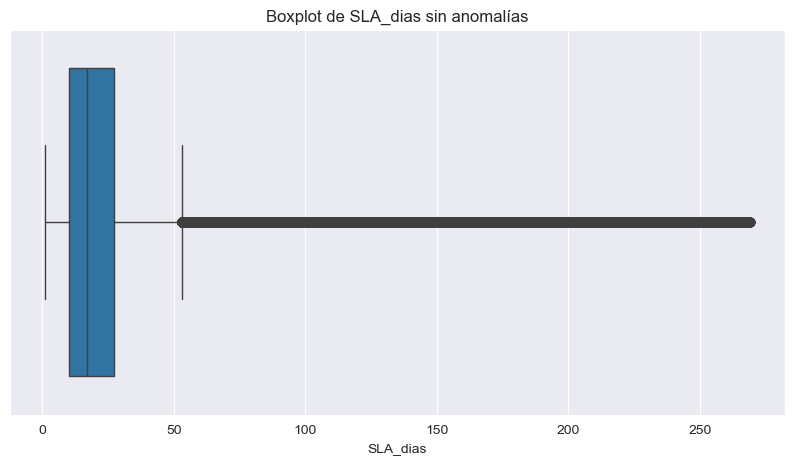

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_limpio_withou_null['SLA_dias'])
plt.title('Boxplot de SLA_dias sin anomalías')
plt.show()


In [39]:
df_limpio_withou_null['SLA_dias'].describe(percentiles=[0.01,0.25,0.5,0.75,0.99])

count    607512.000000
mean         24.989380
std          29.647803
min           1.081713
1%            1.895417
25%          10.116725
50%          16.787801
75%          27.323351
99%         174.230289
max         269.007431
Name: SLA_dias, dtype: float64

### Graficar distribución de SLA_dias

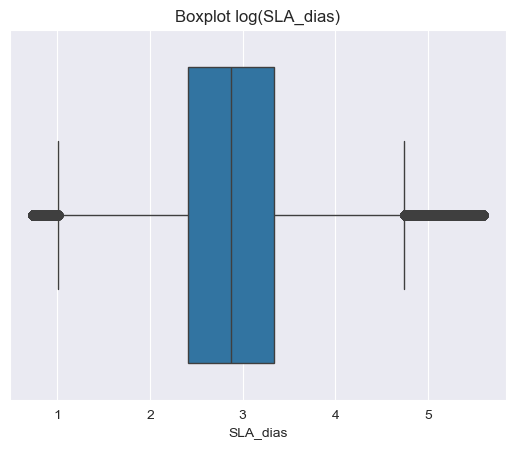

In [40]:
sns.boxplot(x=np.log1p(df_limpio_withou_null['SLA_dias']))
plt.title('Boxplot log(SLA_dias)')
plt.show()

In [41]:
umbral_sla = 60
df_limpio_withou_null['SLA_estado'] = df_limpio_withou_null['SLA_dias'].apply(
    lambda x: 'Fuera de SLA' if x > umbral_sla or x <= 0 else 'Normal'
)

In [42]:
df_limpio_withou_null = df_limpio_withou_null[df_limpio_withou_null['SLA_estado'] == 'Normal']

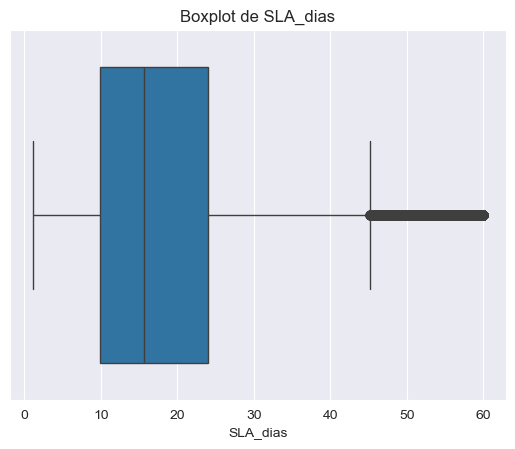

In [43]:
sns.boxplot(x=df_limpio_withou_null['SLA_dias'])
plt.title('Boxplot de SLA_dias')
plt.show()

In [44]:
df_limpio_withou_null = df_limpio_withou_null.drop(columns=['SLA_estado'])

## Determinar que modelo es mas apropiado (Validacion Cruzada)

In [45]:
modelos = {
    "Regresion Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [46]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [47]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [48]:
X = df_limpio_withou_null.drop(columns=['SLA_dias'])
y = df_limpio_withou_null['SLA_dias']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [49]:
resultados = {}
for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y, cv=kf, scoring=rmse_scorer)
    resultados[nombre] = -scores.mean()

In [50]:
for nombre, score in resultados.items():
    print(f"{nombre}: RMSE promedio = {score:.2f}")

Regresion Lineal: RMSE promedio = 11.43
Random Forest: RMSE promedio = 5.85
Gradient Boosting: RMSE promedio = 10.25


### Guardar resultados en MLflow

In [51]:
mlflow.set_experiment("SLA_Model_Tracking")

X = df_limpio_withou_null.drop(columns=['SLA_dias'])
y = df_limpio_withou_null['SLA_dias']

print(f"Datos de entrenamiento: {X.shape[0]:,} filas, {X.shape[1]} columnas\n")

modelos = {
    "Regresion_Lineal": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ============================================
# ENTRENAR Y REGISTRAR EN MLFLOW
# ============================================
for nombre, modelo in modelos.items():
    print("="*60)
    print(f"Entrenando modelo: {nombre}")
    print("="*60)

    with mlflow.start_run(run_name=f"{nombre}_SLA_v1"):
        # Guardar parámetros del modelo
        mlflow.log_param("model", nombre)

        # Medir tiempo de entrenamiento
        inicio = time.time()
        modelo.fit(X, y)
        tiempo = time.time() - inicio

        mlflow.log_metric("training_time_sec", tiempo)

        # Predicciones y métricas
        y_pred = modelo.predict(X)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse_val = rmse(y, y_pred)

        # Loggear métricas
        mlflow.log_metrics({
            "mse": mse,
            "r2": r2,
            "rmse": rmse_val
        })

        # Guardar el modelo
        mlflow.sklearn.log_model(modelo, artifact_path="model")

        print(f"MSE: {mse:.4f} | RMSE: {rmse_val:.4f} | R²: {r2:.4f} | Tiempo: {tiempo:.2f}s")

print("\n✅ Todos los modelos se registraron correctamente en MLflow.")


Datos de entrenamiento: 565,197 filas, 31 columnas

Entrenando modelo: Regresion_Lineal


2025/10/28 23:19:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MSE: 130.6445 | RMSE: 11.4300 | R²: 0.0777 | Tiempo: 0.21s
Entrenando modelo: RandomForest


KeyboardInterrupt: 

## Generar modelo y usarlo

In [45]:
# Nombre del experimento (puedes cambiarlo si quieres separar entrenamientos)
mlflow.set_experiment("SLA_Model_Tracking")

<Experiment: artifact_location='file:///C:/Users/Lenovo/Documents/universidad/Especializacion/ProyectoSegundoSemestrePDS/Proyect/mlruns/633167629003669002', creation_time=1760736778904, experiment_id='633167629003669002', last_update_time=1760736778904, lifecycle_stage='active', name='SLA_Model_Tracking', tags={}>

In [51]:
# ============================================
# PREPARAR DATOS
# ============================================
X = df_limpio_withou_null.drop(columns=['SLA_dias'])
y = df_limpio_withou_null['SLA_dias']

print(f"Datos de entrenamiento: {X.shape[0]:,} filas, {X.shape[1]} columnas\n")

# ============================================
# CREAR Y ENTRENAR RANDOM FOREST + MLflow
# ============================================
print("="*60)
print("ENTRENANDO RANDOM FOREST")
print("="*60)

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---- Configuración de parámetros del modelo ----
params = {
    "n_estimators": 140,
    "max_depth": 17,
    "n_jobs": -1,
    "random_state": 42
}

with mlflow.start_run(run_name="RandomForest_SLA_v1"):
    # Registrar parámetros en MLflow
    mlflow.log_params(params)

    inicio = time.time()
    modelo_rf = RandomForestRegressor(**params, verbose=1)
    print("\nEntrenando modelo...", end=" ", flush=True)
    modelo_rf.fit(X, y)
    tiempo_entrenamiento = time.time() - inicio

    print(f"✓")
    print(f"Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")

    # Log tiempo de entrenamiento como métrica
    mlflow.log_metric("training_time_sec", tiempo_entrenamiento)

    # Si tienes conjunto de validación, evalúalo aquí.
    # Si no, puedes usar el mismo dataset solo para demostrar:
    y_pred = modelo_rf.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Registrar métricas
    mlflow.log_metrics({
        "mse": mse,
        "r2": r2
    })

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(modelo_rf, artifact_path="model")

    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

print("Entrenamiento y registro completados en MLflow ✅")


Datos de entrenamiento: 565,197 filas, 31 columnas

ENTRENANDO RANDOM FOREST

Entrenando modelo... 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   24.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


✓
Tiempo de entrenamiento: 24.64s


[Parallel(n_jobs=32)]: Done 140 out of 140 | elapsed:    0.4s finished
2025/10/17 16:57:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MSE: 53.4185
R²: 0.6229
Entrenamiento y registro completados en MLflow ✅


### Evaluacion del Modelo

In [99]:
y_pred = modelo_rf.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
mae = np.mean(np.abs(y - y_pred))

print(f"\nMétricas:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R²:   {r2:.4f}")


EVALUACIÓN DEL MODELO


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.



Métricas:
  RMSE: 5.9410
  MAE:  4.0963
  R²:   0.7508


[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.3s finished


### Importancia de variables

In [93]:
importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n")
for idx, row in importancia.iterrows():
    porcentaje = row['Importancia'] * 100
    barra = "█" * int(porcentaje / 2)
    print(f"{row['Variable']:30s} {porcentaje:6.2f}% {barra}")


IMPORTANCIA DE VARIABLES


ODSRecepcionTipoServicio        10.47% █████
Fecha_ingreso_dia               10.19% █████
Fecha_ingreso_mes                9.13% ████
ODSRecepcionConfigFabrica        7.62% ███
HistorialODSConfigFabrica        7.59% ███
HistorialODSEstado               5.42% ██
ODSRecepcionFallaSistema         5.00% ██
Fecha_ingreso_ano                4.88% ██
ODSRecepcionLocalDpto            3.82% █
HistorialODSTipoServicio         3.61% █
MarcaId                          2.79% █
ODSRecepcionMarca                2.74% █
ODSRecepcionSedeEntrega          2.64% █
HistorialODSSedeEntrega          2.14% █
HistorialODSMarca                2.09% █
HistorialODSDiagProblema         2.08% █
HistorialODSDpto                 2.07% █
ProblemasId                      2.07% █
ODSRecepcionLocalPais            1.96% 
HistorialODSTipoEquipo           1.76% 
HistorialODSEntregaWeb           1.70% 
ODSRecepcionLocalCiudad          1.56% 
ODSRecepcionRecepcionDpto        1.47% 
ODSRecepcionTipo

### Guardar Modelo

In [100]:
nombre_modelo = "modelo_random_forest_sla_2.joblib"
joblib.dump(modelo_rf, nombre_modelo)
print(f"\n✓ Modelo guardado exitosamente")
print(f"  Archivo: {nombre_modelo}")
print(f"  Tamaño: {os.path.getsize(nombre_modelo) / (1024*1024):.2f} MB")


GUARDANDO MODELO

✓ Modelo guardado exitosamente
  Archivo: modelo_random_forest_sla_2.joblib
  Tamaño: 736.40 MB


### Predicciones con el modelo

In [101]:
print(f"\nPrimeras 5 predicciones:")
print(f"{'Índice':<10} {'Real (días)':<15} {'Predicción (días)':<20} {'Error':<10}")
print("-" * 60)

for i in range(min(5, len(y))):
    y_real = y.iloc[i]
    y_predic = y_pred[i]
    error = y_real - y_predic
    print(f"{i:<10} {y_real:<15.2f} {y_predic:<20.2f} {error:<10.2f}")



EJEMPLO DE PREDICCIONES

Primeras 5 predicciones:
Índice     Real (días)     Predicción (días)    Error     
------------------------------------------------------------
0          22.95           24.76                -1.82     
1          22.95           24.76                -1.82     
2          3.73            4.97                 -1.24     
3          25.72           22.00                3.72      
4          25.72           22.00                3.72      


### Probar modelo manualmente

In [43]:
df_limpio_withou_null.sample(1)

,HistorialODSDiagProblema,HistorialODSMarca,HistorialODSTipoEquipo,HistorialODSEstado,HistorialODSTipoServicio,HistorialODSConfigFabrica,HistorialODSSedeEntrega,HistorialODSDpto,HistorialODSAltaImportancia,HistorialODSEntregaWeb,...,ODSRecepcionFallaSistema,ODSRecepcionChecklist,ODSRecepcionAltaImportancia,ODSRecepcionMarcaEquipoP,ODSRecepcionValorGuiaTras2,MarcaId,SLA_dias,Fecha_ingreso_dia,Fecha_ingreso_mes,Fecha_ingreso_ano
620458,185,3.0,1.0,24.0,7.0,447.0,1006.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,3.0,33.893588,17,3,2021


In [117]:
# Crear DataFrame con los datos de ejemplo (sin la columna SLA_dias ni la columna vacía)
nuevo_registro = pd.DataFrame([{
    'HistorialODSDiagProblema': 185,
    'HistorialODSMarca': 3.0,
    'HistorialODSTipoEquipo': 7.0,
    'HistorialODSEstado': 32.0, # tampoco se toca
    'HistorialODSTipoServicio': 2.0,
    'HistorialODSConfigFabrica': 447.0,
    'HistorialODSSedeEntrega': 1006.0,
    'HistorialODSDpto': 0.0,
    'HistorialODSAltaImportancia': 0.0,
    'HistorialODSEntregaWeb': 0.0,
    'ProblemasId': 185.0,
    'ProblemasTipo': 11.0,
    'TipoProblemaId': 11.0,
    'ODSRecepcionConfigFabrica': 447.0,
    'ODSRecepcionTipoEquipo': 1.0,
    'ODSRecepcionMarca': 3.0,
    'ODSRecepcionRecepcionDpto': 1.0,
    'ODSRecepcionLocalPais': 0.0,
    'ODSRecepcionLocalDpto': 0.0,
    'ODSRecepcionLocalCiudad': 0.0,
    'ODSRecepcionTipoServicio': 2.0,
    'ODSRecepcionSedeEntrega': 1006.0,
    'ODSRecepcionFallaSistema': 7.0,
    'ODSRecepcionChecklist': 0.0,
    'ODSRecepcionAltaImportancia': 0.0,
    'ODSRecepcionMarcaEquipoP': 0.0,
    'ODSRecepcionValorGuiaTras2': 0.0,
    'MarcaId': 3.0,
    'Fecha_ingreso_dia': 16,
    'Fecha_ingreso_mes': 6,
    'Fecha_ingreso_ano': 2028
}])

In [118]:
# Hacer la predicción
prediccion = modelo_rf.predict(nuevo_registro)
prediccion = max(3, prediccion[0])

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished


In [119]:
print("Predicción de SLA_dias:", prediccion)

Predicción de SLA_dias: 32.08254305555553


### Cargar Modelo

In [ ]:
modelo_cargado = joblib.load('modelo_random_forest_sla_2.joblib')

In [ ]:
nueva_prediccion = modelo_cargado.predict(X.iloc[:3])

In [ ]:
print(f"\nPredicciones con modelo cargado:")
for i, pred in enumerate(nueva_prediccion):
    print(f"  Muestra {i+1}: {pred:.2f} días")

### MLflow (Corre en el puerto 5000 del localhost)

In [ ]:
EXPERIMENT_NAME = "SLA_models"
mlflow.set_experiment(EXPERIMENT_NAME)
def log_mlflow_run(model, params: dict, metrics: dict, X_val=None, y_val=None, artifacts: dict=None, run_name: str=None):
    params = {} if params is None else params
    metrics = {} if metrics is None else metrics
    artifacts = {} if artifacts is None else artifacts

    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        if X_val is not None and y_val is not None:
            try:
                y_pred = model.predict(X_val)
            except Exception:
                y_pred = None

            if y_pred is not None:
                try:
                    acc = accuracy_score(y_val, y_pred)
                    f1 = f1_score(y_val, y_pred, average='weighted')
                    mlflow.log_metric('val_accuracy', float(acc))
                    mlflow.log_metric('val_f1_weighted', float(f1))
                    metrics.setdefault('val_accuracy', acc)
                    metrics.setdefault('val_f1_weighted', f1)
                except Exception:
                    pass
                try:
                    cm = confusion_matrix(y_val, y_pred)
                    fig, ax = plt.subplots(figsize=(5,4))
                    ax.matshow(cm)
                    for (i, j), z in np.ndenumerate(cm):
                        ax.text(j, i, str(z), ha='center', va='center')
                    ax.set_title('Confusion matrix')
                    tmpf = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
                    fig.savefig(tmpf.name, bbox_inches='tight')
                    mlflow.log_artifact(tmpf.name, artifact_path='confusion_matrix')
                    tmpf.close()
                    plt.close(fig)
                except Exception:
                    pass
        for k, v in metrics.items():
            try:
                mlflow.log_metric(k, float(v))
            except Exception:
                mlflow.set_tag(f"metric_{k}", str(v))
        for name, path in artifacts.items():
            if os.path.exists(path):
                mlflow.log_artifact(path, artifact_path=name)
        try:
            mlflow.sklearn.log_model(model, artifact_path='model')
        except Exception:
            # fallback: serializar con cloudpickle
            import cloudpickle
            tmp_model = tempfile.NamedTemporaryFile(suffix='.pkl', delete=False)
            with open(tmp_model.name, 'wb') as f:
                cloudpickle.dump(model, f)
            mlflow.log_artifact(tmp_model.name, artifact_path='model')
            tmp_model.close()

In [ ]:
import subprocess
import sys

def launch_mlflow_ui(port: int = 5000, host: str = '127.0.0.1'):
    """Lanza mlflow ui en background y muestra la URL. Ejecutar en Jupyter local.
    Si ya tienes un servidor MLflow separado, no es necesario.
    """
    # intenta ejecutar en background
    cmd = [sys.executable, '-m', 'mlflow', 'ui', '--host', host, '--port', str(port)]
    # Nota: en algunos entornos esto abre un proceso que bloquea la celda. Ejecutamos en segundo plano.
    try:
        if os.name == 'nt':
            # Windows: usar creationflags
            subprocess.Popen(cmd, creationflags=subprocess.CREATE_NEW_CONSOLE)
        else:
            subprocess.Popen(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"MLflow UI lanzado en http://{host}:{port} (si el puerto está libre)")
    except Exception as e:
        print("No se pudo lanzar mlflow ui:", e)


IMPORTANCIA DE VARIABLES
                       Variable  Importancia
20     ODSRecepcionTipoServicio     0.104687
28            Fecha_ingreso_dia     0.101940
29            Fecha_ingreso_mes     0.091346
13    ODSRecepcionConfigFabrica     0.076177
5     HistorialODSConfigFabrica     0.075937
3            HistorialODSEstado     0.054192
22     ODSRecepcionFallaSistema     0.049951
30            Fecha_ingreso_ano     0.048771
18        ODSRecepcionLocalDpto     0.038219
4      HistorialODSTipoServicio     0.036062
27                      MarcaId     0.027930
15            ODSRecepcionMarca     0.027437
21      ODSRecepcionSedeEntrega     0.026444
6       HistorialODSSedeEntrega     0.021435
1             HistorialODSMarca     0.020924
0      HistorialODSDiagProblema     0.020781
7              HistorialODSDpto     0.020717
10                  ProblemasId     0.020681
17        ODSRecepcionLocalPais     0.019625
2        HistorialODSTipoEquipo     0.017632
9        HistorialODSEntregaW

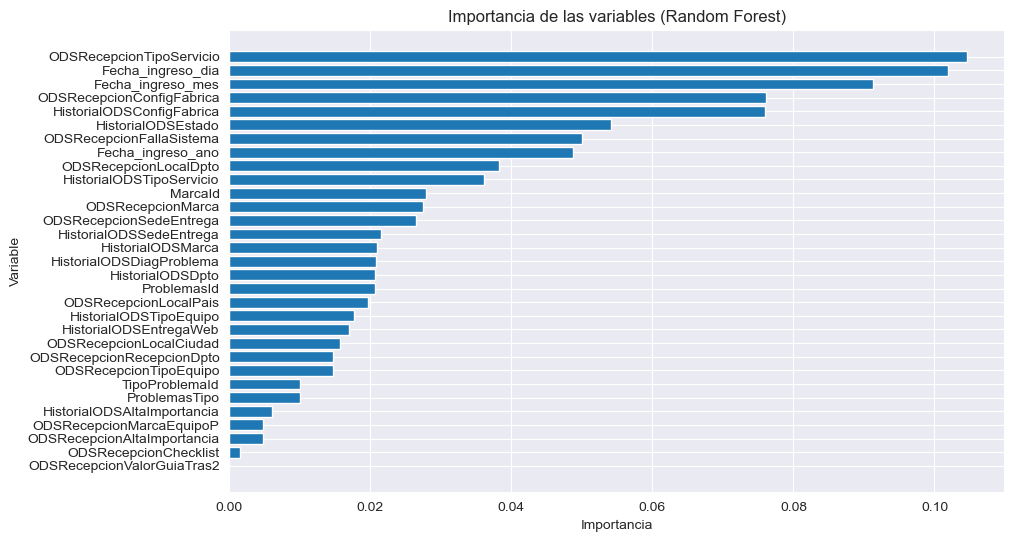

In [51]:
# ============================================
# IMPORTANCIA DE VARIABLES
# ============================================
importancias = modelo_cargado.feature_importances_

# Crear un DataFrame ordenado
importancias_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES")
print("="*60)
print(importancias_df)


plt.figure(figsize=(10,6))
plt.barh(importancias_df['Variable'], importancias_df['Importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de las variables (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


In [53]:
sns.set(style="whitegrid")
try:
    preds = modelo_rf.predict(X)
    model_for_learning = modelo_rf
except NameError:
    preds = modelo_cargado.predict(X)
    model_for_learning = modelo_cargado

y_true = np.asarray(y)
y_pred = np.asarray(preds)
residuals = y_true - y_pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Computed: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Computed: RMSE=5.9410, MAE=4.0963, R²=0.7508


[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.3s finished


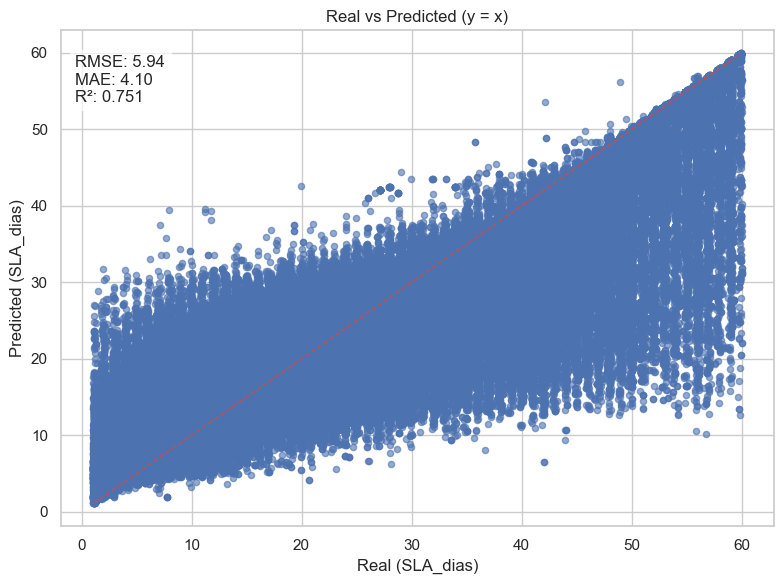

In [54]:
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.6, s=20)
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel("Real (SLA_dias)")
plt.ylabel("Predicted (SLA_dias)")
plt.title("Real vs Predicted (y = x)")
plt.text(0.02, 0.95, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.3f}",
         transform=plt.gca().transAxes, va='top', bbox=dict(facecolor='white', alpha=0.7))
plt.tight_layout()
plt.show()

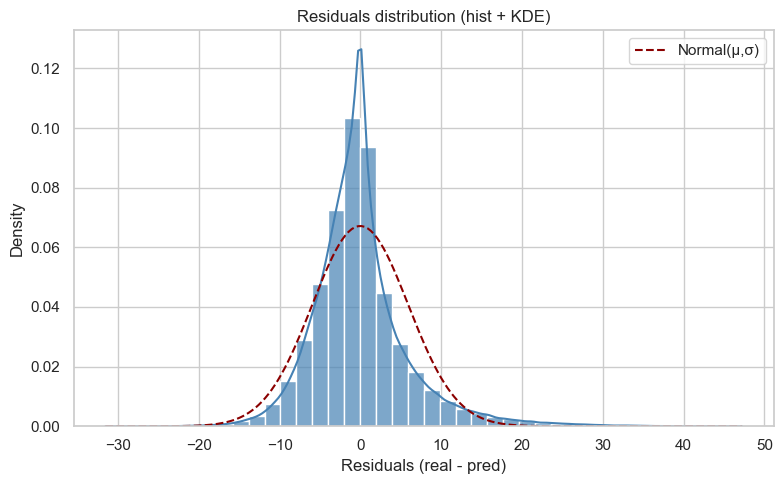

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, stat="density", color='steelblue', alpha=0.7, bins=40)
mu, std = residuals.mean(), residuals.std()
xs = np.linspace(residuals.min(), residuals.max(), 200)
plt.plot(xs, stats.norm.pdf(xs, mu, std), color='darkred', linestyle='--', label='Normal(μ,σ)')
plt.xlabel("Residuals (real - pred)")
plt.title("Residuals distribution (hist + KDE)")
plt.legend()
plt.tight_layout()
plt.show()

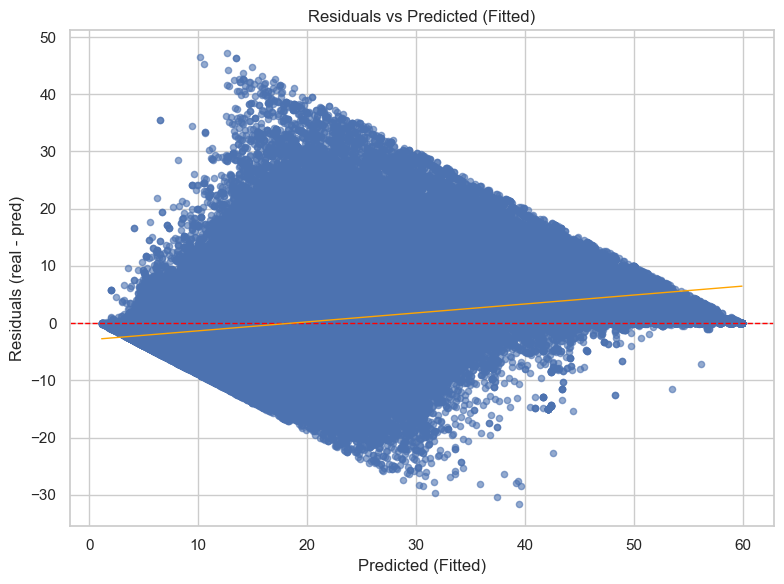

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, s=20)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
if len(y_pred) > 1:
    z = np.polyfit(y_pred, residuals, 1)
    p = np.poly1d(z)
    order = np.argsort(y_pred)
    plt.plot(y_pred[order], p(y_pred[order]), color='orange', linewidth=1)
plt.xlabel("Predicted (Fitted)")
plt.ylabel("Residuals (real - pred)")
plt.title("Residuals vs Predicted (Fitted)")
plt.tight_layout()
plt.show()

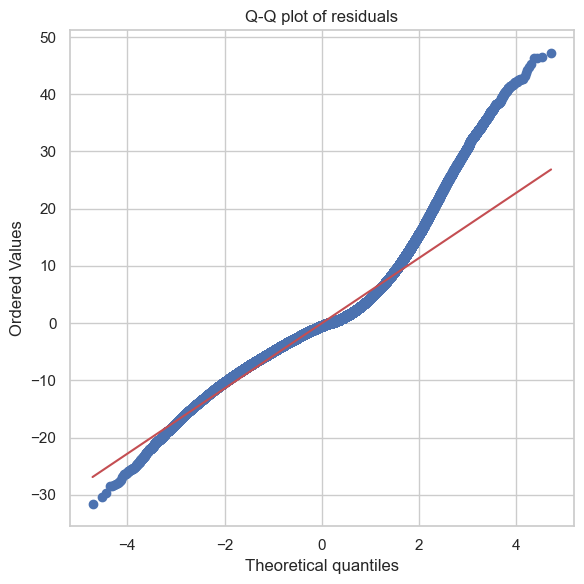

In [57]:
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot of residuals")
plt.tight_layout()
plt.show()

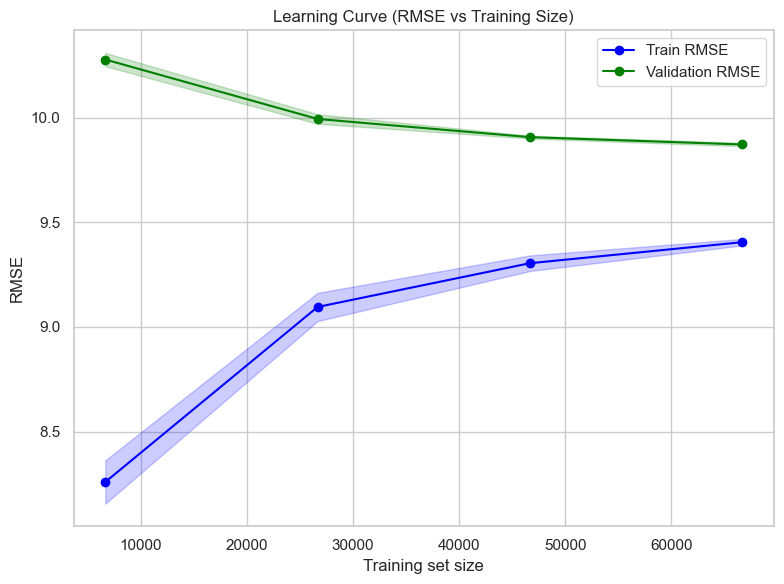

In [60]:
if not isinstance(y_true, pd.Series):
    y_series = pd.Series(y_true, index=X.index)
else:
    y_series = y_true

X_sample, y_sample = shuffle(X, y_series, random_state=42)

if len(X_sample) > 100_000:
    X_sample = X_sample.sample(100_000, random_state=42)
    y_sample = y_sample.loc[X_sample.index]

train_sizes = np.linspace(0.1, 1.0, 4)
scoring = 'neg_mean_squared_error'

model_for_learning_small = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=model_for_learning_small,
    X=X_sample,
    y=y_sample,
    train_sizes=train_sizes,
    cv=3,
    scoring=scoring,
    n_jobs=1,
    shuffle=True,
    random_state=42
)

gc.collect()

train_rmse = np.sqrt(-train_scores).mean(axis=1)
train_rmse_std = np.sqrt(-train_scores).std(axis=1)
test_rmse = np.sqrt(-test_scores).mean(axis=1)
test_rmse_std = np.sqrt(-test_scores).std(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_rmse, 'o-', color='blue', label='Train RMSE')
plt.fill_between(train_sizes_abs, train_rmse - train_rmse_std, train_rmse + train_rmse_std, color='blue', alpha=0.2)
plt.plot(train_sizes_abs, test_rmse, 'o-', color='green', label='Validation RMSE')
plt.fill_between(train_sizes_abs, test_rmse - test_rmse_std, test_rmse + test_rmse_std, color='green', alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE vs Training Size)")
plt.legend()
plt.tight_layout()
plt.show()